# Assignment: QC Mentorship program -   2nd Cohort-   Task 4

### Omid Hassasfar
Omid.Hassasfar@gmail.com

In [1]:
from qiskit import *
from qutip import *
import numpy as np
from random import random
from scipy.optimize import minimize
from qiskit.circuit.library.standard_gates import U2Gate
from qiskit.visualization import *
import matplotlib.pyplot as plt

In [2]:
# M is Hamiltonian that we want to find the minimum eigenvalue

M=np.array([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])  

M      # I choose M (not H) for our Hamiltonian because of confusion with Hadamard gate, since H stands for Hadamard gate

array([[ 1,  0,  0,  0],
       [ 0,  0, -1,  0],
       [ 0, -1,  0,  0],
       [ 0,  0,  0,  1]])

In [3]:
# We can use Qobj from QuTiP instead of array to show our hamiltonian in a better way

M=Qobj([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])  
M

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

In [92]:
# We can directly solve this eigenvalue problem via the function " linalg.eig " and find exact Eigenvectors and Eigenvalues
# from classical eigen solver

eigenvalues, eigenvectors = np.linalg.eigh(M)
print('eigenvalues: ', eigenvalues, 'and corresponding' '\n eigenvectors\n',eigenvectors)
print()
print('Minimum eigenvalue = ', min(eigenvalues))

eigenvalues:  [-1.  1.  1.  1.] and corresponding
 eigenvectors
 [[-0.        -0.j  0.        +0.j  1.        +0.j  0.        +0.j]
 [-0.70710678-0.j -0.70710678+0.j  0.        +0.j  0.        +0.j]
 [-0.70710678-0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [-0.        -0.j  0.        +0.j  0.        +0.j  1.        +0.j]]

Minimum eigenvalue =  -1.0


So the minimum Eigenvalue or in other words **Ground state** energy of this Hamiltonian is **-1**. Since this Hamiltonian was very simple we solved it in a very simple line but now we want to solve this problem with **VQE** (*Variational Quantum Eigensolver*)

First of all we should write our hamiltonian in terms of products of four Pauli-matrices. Since our Hamiltonian matrix is $ 4*4$ (2-qubit Hamiltonian), generally we have 16 terms and each term has a coefficient. one can find these coefficient using this formula as a Decomposing Two-Qubit Hamiltonians into a sum of tensor products of **Pauli-Matrices** weighted by constant coefficients.

\begin{array}{l}
M = \sum\limits_{i,j = 1,x,y,z} {{a_{i,j}}({\sigma _i} \otimes {\sigma _j})} \;\;\,\,,\,\,\,\,\,\,{a_{i,j}}\, = \frac{1}{4}tr\,[({\sigma _i} \otimes {\sigma _j})M]\\
\\
{\sigma _1} = \left( {\begin{array}{*{20}{c}}
1&0\\
0&1
\end{array}} \right)\,\,\,\,,\,\,\,{\sigma _x} = \left( {\begin{array}{*{20}{c}}
0&1\\
1&0
\end{array}} \right)\,\,\,\,,\,\,\,{\sigma _y} = \left( {\begin{array}{*{20}{c}}
0&{ - i}\\
i&0
\end{array}} \right)\,\,\,\,,\,\,\,{\sigma _z} = \left( {\begin{array}{*{20}{c}}
1&0\\
0&{ - 1}
\end{array}} \right)
\end{array}

After calculation we can easily find that the coefficient of all terms are zero exept terms consisting of the same matrices.
and just 4 terms left. 
$ZZ & XX & YY & II$

So as a result Hamilton is written like this:
$
\begin{align}
M = \frac{1}{2}\left( I \otimes I-X \otimes X- Y \otimes Y+ Z \otimes Z\right)
\end{align}
$

In [4]:
# Define the Pauli matrices 

I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,0-1j],[0+1j,0]])
Z = np.array([[1,0],[0,-1]])

In [5]:
# Compute the tensor product of the Pauli matrices

XX = np.kron(X,X)
YY = np.kron(Y,Y)
ZZ = np.kron(Z,Z)
II = np.kron(I,I)

In [95]:
# This is the decomposition of the "M" matrix (Hamiltonian) 
M= (II-XX-YY+ZZ)/2
M

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [6]:
Qobj(M)
# So you can see this decomposition as a 4 terms of products of pauli matrices is exatly our hamiltonian matrix

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

# Expectation value of two-qubit operatorse
we have 4 terms in Hamiltonian and the expectation value of Hamiltonian is the sum of expectation value of all of them seperately.
Since We are only able to perform measurment in Z basis, we can measure $ZZ$ easily and the $II$ term just left a constant but for $XX$ and $YY$ terms we should apply a transformation according to these equations :

in the **computational basis** 
> Remember that, given a general qubit state $|\psi\rangle=\alpha |0\rangle + \beta |1\rangle$, it holds $\langle Z \rangle = \langle \psi | Z | \psi \rangle = |\alpha|^2-|\beta|^2$.and we know  the operator $Z_1 Z_2$ acts like: 
$$
Z_1 Z_2|00\rangle = +1 |00\rangle \\
Z_1 Z_2|11\rangle = +1 |11\rangle \\
Z_1 Z_2|01\rangle = -1 |01\rangle \\
Z_1 Z_2|10\rangle = -1 |10\rangle \\
$$

### Change of basis

\\begin{array}{l}
\left\langle \Psi  \right.\left| {XX} \right.\left| \Psi  \right\rangle  = \left\langle {\Psi \left| {{U^\dagger }} \right.U} \right.\left. {\left| X \right.X} \right|{U^\dagger }U\left| \Psi  \right\rangle  = \left\langle {\Psi \left| {{U^\dagger }} \right.} \right.\left. {\left| Z \right.Z} \right|U\left| \Psi  \right\rangle  = \left\langle {{\Phi _1}} \right.\left| {YY} \right.\left| {{\Phi _1}} \right\rangle \\
\left| {{\Phi _1}} \right\rangle  = {U_1}\left| \Psi  \right\rangle \\
\\
\left\langle \Psi  \right.\left| {YY} \right.\left| \Psi  \right\rangle  = \left\langle {\Psi \left| {{U^\dagger }} \right.U\left| Y \right.} \right.\left. Y \right|{U^\dagger }U\left| \Psi  \right\rangle  = \left\langle {\Psi \left| {{U^\dagger }} \right.} \right.\left. {\left| Z \right.Z} \right|U\left| \Psi  \right\rangle  = \left\langle {{\Phi _2}} \right.\left| {YY} \right.\left| {{\Phi _2}} \right\rangle \\
\left| {{\Phi _2}} \right\rangle  = {U_2}\left| \Psi  \right\rangle 
\end{array}

We know : $$
X=HZH\quad \,\,\,\,\,\   Y=(HS^\dagger)^\dagger Z(HS^\dagger)
$$


for **XX** term we can use the famous Hadamard gate (tensor product) $U_1=H$ and $U_2=H$ 
and for **YY** case we can use  $U_2=HS^\dagger$

Note that for tensor products of operators like $XX$  Pauli term (actually $XX= X \otimes X$) .


$
S^\dagger = \begin{bmatrix}
1 & 0 \\
0 & -i
\end{bmatrix}.
$  ,                 $
H =\frac{1}{{\sqrt 2 }}  \begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}.
$

$$U_1 \otimes U_2 \left| \psi_1 \right\rangle \otimes \left| \psi_2 \right\rangle =  U_1 \left| \psi_1 \right\rangle \otimes U_2 \left| \psi_2 \right\rangle,$$

were $U_1$ and $U_2$ are some unitary operators acting on two qubits with separate $\left| \psi_1 \right\rangle$ and $\left| \psi_2 \right\rangle$ wavefunctions. 


finally to determine the expectation value on our trial states, we seek to decompose all 2-qubit operators into the form

$
O = U^{\dagger} \left( Z_1 \otimes Z_2 \right) U,
$

where $U$ is a unitary matrix specific to $O$. For our purposes, the following decompositions are relevant


$
\begin{align}
X \otimes X &= \left(H_1 \otimes H_2 \right)^\dagger Z_1 \otimes Z_2  \left(H_1 \otimes H_2 \right), \\
Y \otimes Y &= \left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right)^\dagger Z_1 \otimes Z_2  \left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right),
\end{align}
$

$
\begin{align}  
\left| \phi_1 \right> &=  \left(H \otimes H \right) \left|\psi \right>, \\  
\left| \phi_2 \right> &= \left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right) \left|\psi \right>,  
\end{align}  
$

>An altarnative way to apply unitary transformation is to use default $u_2$ gates in **Qiskit** where

\begin{array}{l}
{u_2}(\varphi ,\lambda ) = \frac{1}{{\sqrt 2 }}\left( {\begin{array}{*{20}{c}}
1&{ - {e^{i\lambda }}}\\
{{e^{i\varphi }}}&{{e^{i(\varphi  + \lambda )}}}
\end{array}} \right)\,\\
{u_2}(0,\pi ) = \,\frac{1}{{\sqrt 2 }}\left( {\begin{array}{*{20}{c}}
1&1\\
1&{ - 1}
\end{array}} \right)\, = H\\
{u_2}(0,\frac{\pi }{2}) = \,\frac{1}{{\sqrt 2 }}\left( {\begin{array}{*{20}{c}}
1&{ - i}\\
1&i
\end{array}} \right)\, = H{S^\dagger }\,
\end{array}

# Variational wave function Anzatz state

Now that we know how to compute the expectation value of our matrix $M$ we need a trial wavefunction. As per the hint, we will use the state given by

$
\begin{align}
\left| \psi (\theta)\right> = (R_X(\theta) \otimes I)(CX)(H \otimes I) \left| 00 \right>.
\end{align}
$

We produce a simple visualization of this state below

In [7]:
# Visualize Ansatz-circuit
theta=np.pi
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q,c)
circuit.h(q[0])
circuit.id(q[1])
circuit.cx(q[0],q[1])
circuit.rx(theta,q[0])
circuit.id(q[1])
circuit.barrier()
circuit.draw()

┌───┐     ┌────────┐ ░ 
q0_0: ┤ H ├──■──┤ RX(pi) ├─░─
      ├───┤┌─┴─┐└─┬───┬──┘ ░ 
q0_1: ┤ I ├┤ X ├──┤ I ├────░─
      └───┘└───┘  └───┘    ░ 
c0: 2/═══════════════════════

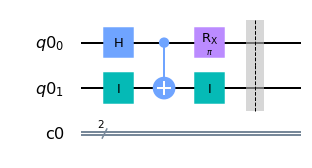

In [8]:
# another way to show circuit :) 
circuit.draw(output='mpl')

In [9]:
def anzatz(circuit,q,c,theta):
    '''
    The Anzatz wave function
    |psi > = (Rx(theta) I)(CX)(H I)|00>
    '''
    circuit.h(q[0])
    circuit.id(q[1])
    circuit.cx(q[0],q[1])
    circuit.rx(theta,q[0])
    circuit.id(q[1])
    circuit.barrier()    
    
    return circuit

def measure_ZZ(circuit,N_shots=2**10,simulator_backend='qasm_simulator'):
    '''
    Measures the expectation value of ZZ on the 2-qubit states
    
    <ZZ> = the number of ( 00 )  and (11) states, minus the number of (01) and (10) states
    normalized over the number of trials
    '''
    simulator = Aer.get_backend(simulator_backend)
    result = execute(circuit,backend=simulator,shots=N_shots).result()

    items =result.get_counts().items()
    
    s = 0
    for key, counts in items:
        s+= (-1)**(int(key[0])+int(key[1]))*counts
    
    s = s/N_shots
        
    return s

def hamiltonian(theta,N_shots=2**10):
    '''
    The hamiltonian for the problem that corresponds 
    to our matrix M:
    
    M = (1/2)*(II-XX-YY+ZZ)
    
    The hamiltonian is computed by separating it into three components
    according to the discussions in the previous cells. 
    '''
    
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    
    ## 0.5*XX component
    circuit_xx = QuantumCircuit(q,c)
    circuit_xx = anzatz(circuit_xx,q,c,theta)
    circuit_xx.h(q[0])
    circuit_xx.h(q[1])
    circuit_xx.measure(q,c)
    E_XX = -0.5*measure_ZZ(circuit_xx,N_shots=N_shots)
    
    ## 0.5*YY component
    circuit_yy = QuantumCircuit(q,c)
    circuit_yy = anzatz(circuit_yy,q,c,theta)
    circuit_yy.sdg(q[0])
    circuit_yy.h(q[0])
    circuit_yy.sdg(q[1])
    circuit_yy.h(q[1])    
    circuit_yy.measure(q,c)
    E_YY= -0.5*measure_ZZ(circuit_yy,N_shots=N_shots)
    
    
    # 0.5*ZZ component
    circuit_zz = QuantumCircuit(q,c)
    circuit_zz = anzatz(circuit_zz,q,c,theta)
    circuit_zz.measure(q,c)
    E_ZZ = 0.5*measure_ZZ(circuit_zz,N_shots=N_shots)
    
    # Note, the +1/2 comes from the fact that <psi|II|psi> = 1
    # it is always a constant
    
    return (E_XX+E_YY+E_ZZ+0.5)

#### Circuit for ZZ measurement with initial parameters

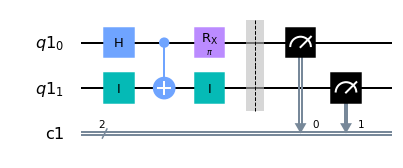

In [10]:
# Visualize Ansatz-circuit
theta=np.pi
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q,c)
circuit.h(q[0])
circuit.id(q[1])
circuit.cx(q[0],q[1])
circuit.rx(theta,q[0])
circuit.id(q[1])
circuit.barrier()
circuit.measure([0,1], [0,1])
circuit.draw(output='mpl')

#### Circuit for XX measurement with initial parameters

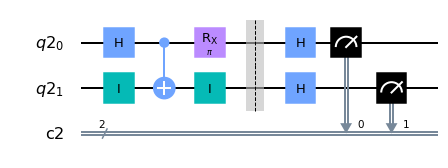

In [11]:
# Visualize Ansatz-circuit
theta=np.pi
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q,c)
circuit.h(q[0])
circuit.id(q[1])
circuit.cx(q[0],q[1])
circuit.rx(theta,q[0])
circuit.id(q[1])
circuit.barrier()
circuit.h(q[0])
circuit.h(q[1])
circuit.measure([0,1], [0,1])
circuit.draw(output='mpl')

#### Circuit for YY measurement with initial parameters

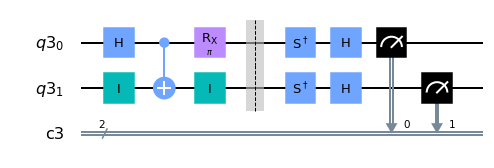

In [12]:
# Visualize Ansatz-circuit
theta=np.pi
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q,c)
circuit.h(q[0])
circuit.id(q[1])
circuit.cx(q[0],q[1])
circuit.rx(theta,q[0])
circuit.id(q[1])
circuit.barrier()
circuit.sdg(q[0])
circuit.h(q[0])
circuit.sdg(q[1])
circuit.h(q[1])
circuit.measure([0,1], [0,1])
circuit.draw(output='mpl')

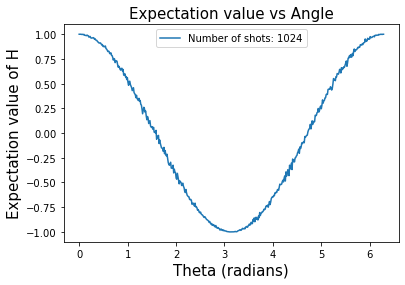

--------------------------------------------------------------------------------
The minimum bound on the lowest eigenvalue of M is E0=-1.0,

The parameter that corresponds to this energy is theta=3.10 Rads
--------------------------------------------------------------------------------


In [13]:
# Now we generate several thetas as a variational parameter, and find the best set of parameters

import matplotlib.pyplot as plt

# The number of trials to run
N_shots = 2**10

# Generate theta grid from Theta to 2*Pi
theta = np.linspace(0.0,2*np.pi,500)
E = np.zeros(len(theta)) 

# Calculate the expectation value of the Hamiltonian for different theta
for k in range(len(theta)):
    E[k] =  hamiltonian(theta=theta[k],N_shots=N_shots)
    

# Plot the results
plt.title('Expectation value vs Angle',fontsize=15)
plt.ylabel('Expectation value of H',fontsize=15)
plt.xlabel('Theta (radians)',fontsize=15)
plt.plot(theta,E,label='Number of shots: {}'.format(N_shots))
plt.legend()
plt.show()
    

# Determine the lowest bound from varying theta
print('--'*40)
print('The minimum bound on the lowest eigenvalue of M is E0={},\n'.format(min(E)))
print('The parameter that corresponds to this energy is theta={:0.2f} Rads'.format(theta[np.argmin(E)]))
print('--'*40)

In [14]:
import qiskit.tools.jupyter
%qiskit_version_table

## References : 

### For basic concepts of VQE 

[Michał Stęchły]           (https://www.mustythoughts.com/variational-quantum-eigensolver-explained)

[Famous Article!]          (https://www.nature.com/articles/ncomms5213)

[James Weaver]        (https://medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747)

### For Understanding of Decomposition of Pauli Matrices and Measurment in computational basis: 

[Pauli Measurements]       (https://docs.microsoft.com/en-us/quantum/concepts/pauli-measurements)

[Michael Goerz]           (https://michaelgoerz.net/notes/decomposing-two-qubit-hamiltonians-into-pauli-matrices.html )



###  Very useful Github link that help me a lot ! 

[Oscar Javier Hernandez]   (https://github.com/OscarJHernandez/qc_mentorship_task)

[Michał Stęchły]           (https://github.com/mstechly/mustythoughts_plus/blob/master/VQE_QAOA/VQE_explained_example.ipynb)


[Davit Khachatryan] 
(https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb)

[Alexander Soare]          (https://github.com/alexander-soare/framework-agnostic-vqe-tutorial)


### Qiskit ! 

(https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html)

https://qiskit.org/textbook/ch-applications/vqe-molecules.html